# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Final Project: Rare Sneaker Prices


**Harvard University**<br/>
**Fall 2021**<br/>
**Students**: Tyler Barnett, Weston Ruths, Pragya Tooteja, Kishan Venkataramu

<hr style="height:2pt">



In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
import itertools
import math

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype

import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

from pandas.plotting import scatter_matrix

# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

%matplotlib inline

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)

  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

In [3]:
data = pd.read_csv("data/StockX-Data.csv")
np.random.seed(121)

# Convert dates to ordinals
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Order Date'] = data['Order Date'].map(dt.datetime.toordinal)

data['Release Date'] = pd.to_datetime(data['Release Date'])
data['Release Date'] = data['Release Date'].map(dt.datetime.toordinal)

# Convert Brand to categorical variable
cat_type = CategoricalDtype(ordered=False)
data['Brand'] = data['Brand'].astype(cat_type)
data['Sale Price']= data['Sale Price'].str.replace(',', '')
data['Sale Price']= data['Sale Price'].str.replace('$','')
data['Sale Price']= data['Sale Price'].astype(float)

data_train, data_test = train_test_split(
    data,
    test_size=0.2,
    random_state=121,
    shuffle=True,
)

print(data.shape)
print(data_train.shape, data_test.shape)

(99956, 8)
(79964, 8) (19992, 8)


/var/folders/qn/jm_q__6d5jzb_g950nmyw01m0000gn/T/ipykernel_28599/1151195166.py:15: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Sale Price']= data['Sale Price'].str.replace('$','')


In [4]:
data.dtypes

Order Date         int64
Brand           category
Sneaker Name      object
Sale Price       float64
Retail Price      object
Release Date       int64
Shoe Size        float64
Buyer Region      object
dtype: object

In [5]:
data_train.head()
print("Hello World")

Hello World


array([[<AxesSubplot:xlabel='Order Date', ylabel='Order Date'>,
        <AxesSubplot:xlabel='Sale Price', ylabel='Order Date'>,
        <AxesSubplot:xlabel='Release Date', ylabel='Order Date'>,
        <AxesSubplot:xlabel='Shoe Size', ylabel='Order Date'>],
       [<AxesSubplot:xlabel='Order Date', ylabel='Sale Price'>,
        <AxesSubplot:xlabel='Sale Price', ylabel='Sale Price'>,
        <AxesSubplot:xlabel='Release Date', ylabel='Sale Price'>,
        <AxesSubplot:xlabel='Shoe Size', ylabel='Sale Price'>],
       [<AxesSubplot:xlabel='Order Date', ylabel='Release Date'>,
        <AxesSubplot:xlabel='Sale Price', ylabel='Release Date'>,
        <AxesSubplot:xlabel='Release Date', ylabel='Release Date'>,
        <AxesSubplot:xlabel='Shoe Size', ylabel='Release Date'>],
       [<AxesSubplot:xlabel='Order Date', ylabel='Shoe Size'>,
        <AxesSubplot:xlabel='Sale Price', ylabel='Shoe Size'>,
        <AxesSubplot:xlabel='Release Date', ylabel='Shoe Size'>,
        <AxesSubplot:xlabel

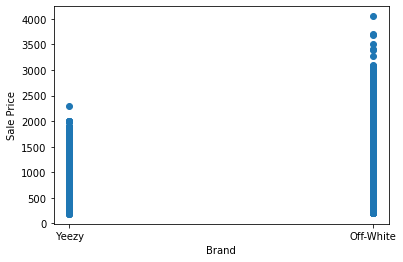

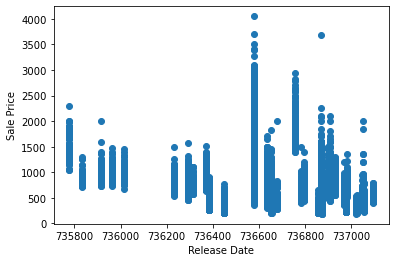

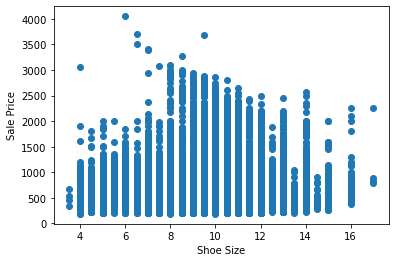

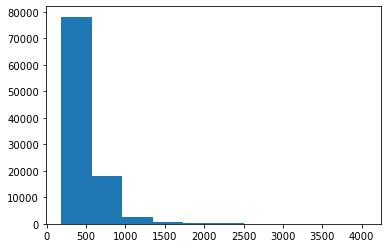

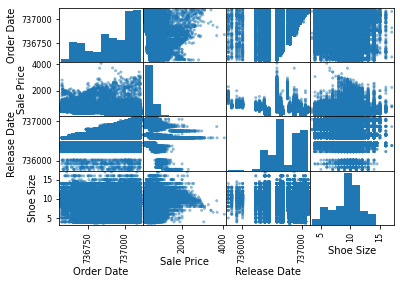

In [6]:
attr_list = [
    "Order Date",
    "Brand",
    "Sneaker Name",
    "Sale Price",
    "Retail Price",
    "Release Date",
    "Shoe Size",
    "Buyer Region"
]

plt.scatter(data['Brand'], data['Sale Price'])
plt.xlabel('Brand')
plt.ylabel('Sale Price')

plt.figure()

plt.scatter(data['Release Date'], data['Sale Price'])
plt.xlabel('Release Date')
plt.ylabel('Sale Price')

plt.figure()
plt.scatter(data['Shoe Size'], data['Sale Price'])
plt.xlabel('Shoe Size')
plt.ylabel('Sale Price')

plt.figure()
plt.hist(data['Sale Price'])

scatter_matrix(data[attr_list])

Text(0.5, 1.0, 'Average Sale Price for Release Date')

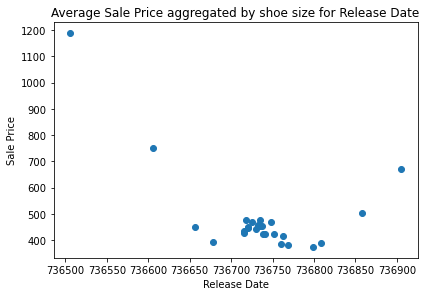

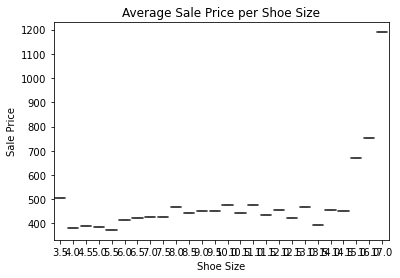

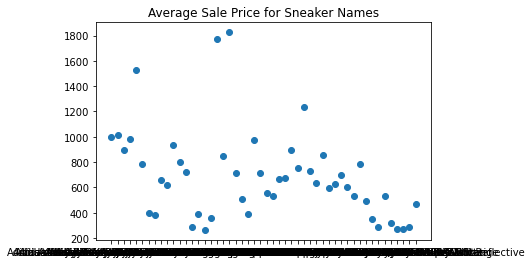

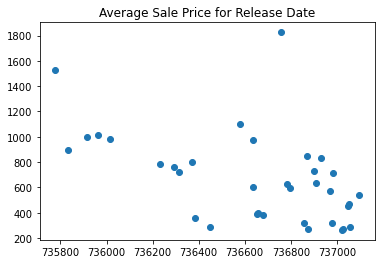

In [10]:
#Aggregating by Shoe Size
data1= data.groupby(by= ['Shoe Size']).mean()
plt.scatter(data1['Release Date'], data1['Sale Price'])
plt.xlabel('Release Date')
plt.ylabel('Sale Price')
plt.tight_layout()
plt.title('Average Sale Price aggregated by shoe size for Release Date')
plt.figure()
sns.boxplot(x=data1.index, y=data1['Sale Price'])
plt.title('Average Sale Price per Shoe Size')

plt.figure()

data2= data.groupby(by= ['Release Date']).mean()
data3= data.groupby(by= ['Sneaker Name']).mean()
plt.scatter(data3.index, data3['Sale Price'])
plt.title('Average Sale Price for Sneaker Names')

plt.figure()

#Add Average Sale Price of Sneaker Name 
#Number of Sneaker Sales by Shoe Size
#Number of Sneakers by Sneaker Name


plt.scatter(data2.index, data2['Sale Price'])
plt.title('Average Sale Price for Release Date')
#plt.setp(plt.get_xticklabels(), rotation=30, horizontalalignment='right')
#sns.tight_layout()

<a id="intro"></a>

## Baseline Model

[Return to contents](#contents)

In [8]:
# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "Sale Price"].values
y_train = data_train["Sale Price"].values
X_test = data_test.iloc[:, data_test.columns != "Sale Price"].values
y_test = data_test["Sale Price"].values

In [9]:
train_scores = {}
cvmeans = {}
cvstds = {}

tree_depth_start, tree_depth_end = 1, 20
for i in range(tree_depth_start, tree_depth_end + 1):
    
    #declare tree model object
    model = DecisionTreeClassifier(max_depth=i)
    
    #fit the decision tree to the entire training set
    model.fit(X_train, y_train)
    
    #Evaluate on the entire training set (i.e., .score(...)), while storing the scores in a variable named train_scores.
    train_scores[i] = model.score(X_train, y_train)
    
    #get cv metrics
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    cvmeans[i] = scores.mean()
    cvstds[i] = np.std(scores)

ValueError: could not convert string to float: ' Yeezy'

#### THE END

[Return to contents](#contents)